In [1]:
import torch
import os
import numpy as np
import NeuralTSNE as ntsne
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Subset, ConcatDataset
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer

In [2]:
# Load the dataset and split it into training and testing sets
try:
  train, test = ntsne.DatasetLoader.get_datasets.prepare_dataset("colvar")
except FileNotFoundError:
  print("Dataset not found. Please download the dataset first.")
  exit(1)
  
val = Subset(train, range(0, len(test)))
train = Subset(train, range(len(test), len(train)))

In [3]:
features = train.dataset[0][0].size(0)
reduced_features = 2
multipliers = [0.75, 0.75, 0.75]
basic_model = ntsne.TSNE.NeuralNetwork.NeuralNetwork(
    features, reduced_features, multipliers
)

In [4]:
param_tsne = ntsne.TSNE.ParametricTSNE.ParametricTSNE(
    loss_fn="kl_divergence",
    n_components=reduced_features,
    perplexity=30,
    batch_size=1000,
    early_exaggeration_epochs=0,
    early_exaggeration_value=0,
    max_iterations=500,
    features=features,
    multipliers=multipliers,
)

In [5]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10)
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=50,
    max_epochs=param_tsne.max_iterations,
    callbacks=[early_stopping],
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\skaii\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
reducer = ntsne.TSNE.Modules.DimensionalityReduction(param_tsne, False, lr=1e-3)

traind, testd = param_tsne.create_dataloaders(train, test)
vald, _ = param_tsne.create_dataloaders(val, None)

all_data = ConcatDataset([train, val, test])
all_loader, _ = param_tsne.create_dataloaders(all_data, None)

In [7]:
torch.set_float32_matmul_precision("high")

if os.path.exists("colvar_model.pt"):
    param_tsne.read_model("colvar_model.pt")
else:
    trainer.fit(reducer, traind, [vald])
    param_tsne.save_model("colvar_model.pt")

In [8]:
Y = trainer.predict(reducer, testd)
Y = np.concatenate(Y, axis=0)

header = ','.join(["x1", "x2"])
np.savetxt("colvar_2d.csv", Y, header=header, delimiter=",")

x = Y[:, 0]
y = Y[:, 1]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\skaii\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 178.16it/s]


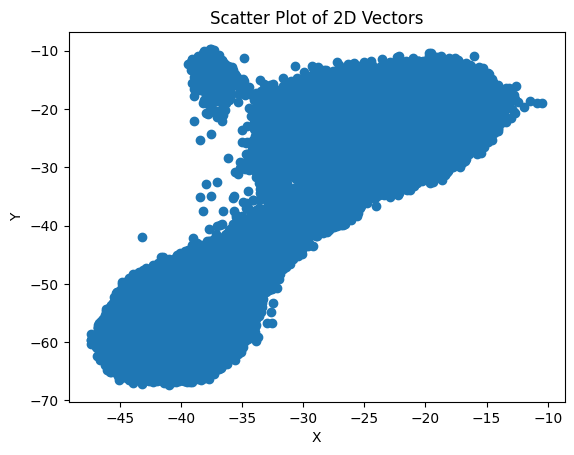

In [9]:
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of 2D Vectors")

plt.show()